In [26]:
import pandas as pd
import pytz
import urllib3
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np
urllib3.disable_warnings()
import pandas as pd
import urllib3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from datetime import datetime
from IPython.core.display import display, HTML
import matplotlib as mpl
from collections import OrderedDict
import numpy as np
from influxdb import InfluxDBClient as InfluxDBClient_old_version
from csv import DictReader
import os
import collections
import random
import json
import math
import requests
import io

import matplotlib
matplotlib.rcParams['timezone'] = 'US/Eastern'

pd.options.mode.chained_assignment = None  # default='warn'
display(HTML('<style>.container { width:100% !important; }</style>'))
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = [24, 12]
plt.style.use('seaborn-whitegrid')
sns.set(font_scale=1.7)
sns.set_context("poster")
sns.set_style("whitegrid")
urllib3.disable_warnings()

import rx
from rx import operators as ops

from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write.retry import WritesRetry
from influxdb_client.client.write_api import SYNCHRONOUS
import geocoder
import glob
from influxdb_client.domain.write_precision import WritePrecision

import dataretrieval.nwis as nwis

C:\Users\sadhv\AppData\Local\Temp\ipykernel_18192\3167494877.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### Floodnet Data

In [27]:
def pull_flood_data(_url='https://influxdb.floodnet.nyc',
                                    _token='rvEpEpb9bDwrb1NbmlbnmT4HT_XCQxeKn3DHghJu9uABrm1qbHhR9D8eXsoMux9v073wttFRY6FLs6FxM7TuSw==',
                                    _org='floodnet',
                                    dep_id=None,
                                    save_to_location=None,
                                    start_date=None,
                                    stop_date=None,):
    # TBD feature: query from start to stop date ranges passed as function arguments
    result = []
    
    # start_date = pd.to_datetime(start_date, format='%Y-%m-%dT%H:%M:%S%z')
    # stop_date = pd.to_datetime(stop_date, format='%Y-%m-%dT%H:%M:%S%z')
        
    p = {"_deployment_id": dep_id,}
        #  "_start_date" : start_date, 
        #  "_stop_date" : stop_date,
        # }

    with InfluxDBClient(url=_url, token=_token, org=_org, timeout=1000000) as client:
        query_api = client.query_api()
        query_string = '''from(bucket: "floodnet-live")
                                    |> range(start: 0, stop: now())
                                    |> filter(fn: (r) => r["_measurement"] == "tidal-sensor")
                                    |> filter(fn: (r) => r["deployment_id"] == _deployment_id)
                                    |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
                                '''
        result = query_api.query_data_frame(query_string, params=p)
        if type(result) == list:
            result = pd.concat(result)

    result.drop(columns=['_start', '_stop', 'result', 'table'], inplace=True)
    result.rename(columns={'_time': 'time', '_measurement': 'measurement'}, inplace=True)
    result['time'] = pd.to_datetime(result['time'], format="%Y-%m-%d %H:%M:%S.%f", utc=True)
    result.set_index('time', inplace=True)
    result = result.sort_values(by=['time'])
    return result

In [30]:
depID =  'yearly_unique_eagle'
start = '2022-08-01T00:00:00+00:00'
end = '2022-08-08T00:00:00+00:00'

df = pull_flood_data(dep_id=depID, start_date=start,stop_date=end)

### NOAA Data (Aug 1st to 7th)

In [31]:
url = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date=20220801&end_date=20220808&station=8518750&product=water_level&datum=mllw&units=metric&time_zone=gmt&format=csv"
noaa_data = pd.read_csv(url)
noaa_data['Date Time'] = pd.to_datetime(noaa_data['Date Time'], format='%Y-%m-%dT%H:%M:%S%z')

x1 = np.array(noaa_data['Date Time'])
y1 = np.array(noaa_data[' Water Level'])

noaa_data

,Date Time,Water Level,Sigma,O or I (for verified),F,R,L,Quality
0,2022-08-01 00:00:00,1.198,0.032,1,0,0,0,p
1,2022-08-01 00:06:00,1.240,0.032,1,0,0,0,p
2,2022-08-01 00:12:00,1.275,0.024,1,0,0,0,p
3,2022-08-01 00:18:00,1.311,0.024,1,0,0,0,p
4,2022-08-01 00:24:00,1.348,0.048,0,0,0,0,p
...,...,...,...,...,...,...,...,...
1915,2022-08-08 23:30:00,1.405,0.073,0,0,0,0,p
1916,2022-08-08 23:36:00,1.383,0.066,1,0,0,0,p
1917,2022-08-08 23:42:00,1.358,0.045,1,0,0,0,p
1918,2022-08-08 23:48:00,1.330,0.033,1,0,0,0,p


### Plotting Floodnet Tidal Data

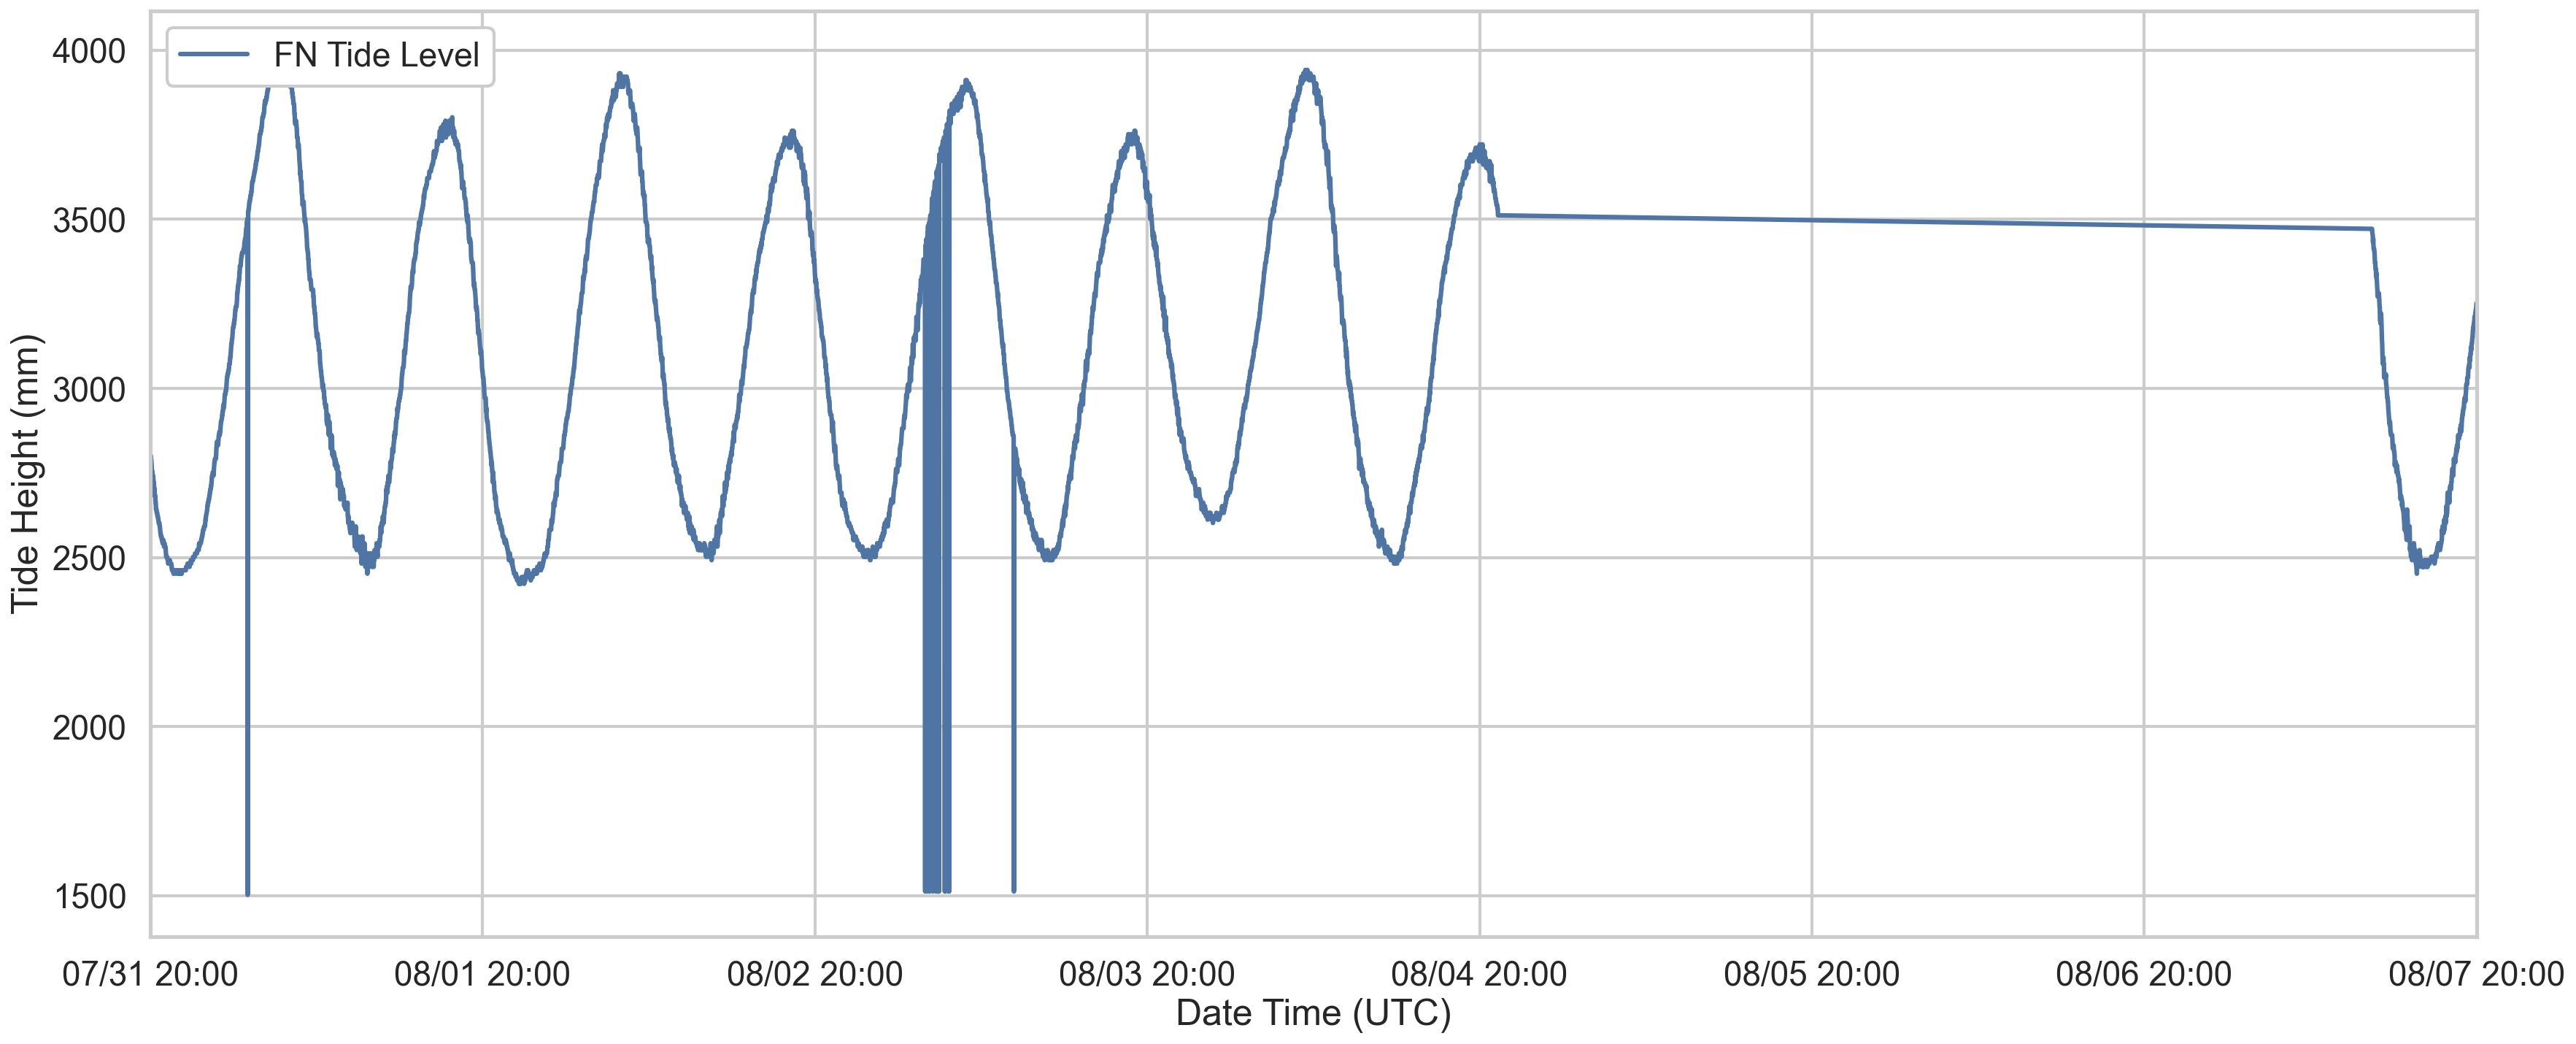

In [32]:
df['time'] = df.index
df = df[df['time'].dt.year > 2021]
df = df[df['time'].dt.month > 7]
df = df[df['time'].dt.day <8]

x2 = np.array(df['time'])
y2 = np.array(df['dist_mm'])

figure, ax_arry = plt.subplots(nrows=1, sharex=True, figsize=(24, 10))
noaa_color = '#4e75a3'
sensor_color = '#3d805a'
ax_arry.plot(x2, y2, color=noaa_color, label='FN Tide Level')

ax_arry.set_xlim(pd.Timestamp(start), pd.Timestamp(end))
ax_arry.set_ylabel("Tide Height (mm)")
ax_arry.set_xlabel("Date Time (UTC)")
ax_arry.legend(framealpha=1, frameon=True, loc='upper left')
date_form = mdates.DateFormatter("%m/%d %H:%M")
ax_arry.xaxis.set_major_formatter(date_form)


plt.tight_layout(pad=1)
plt.show()

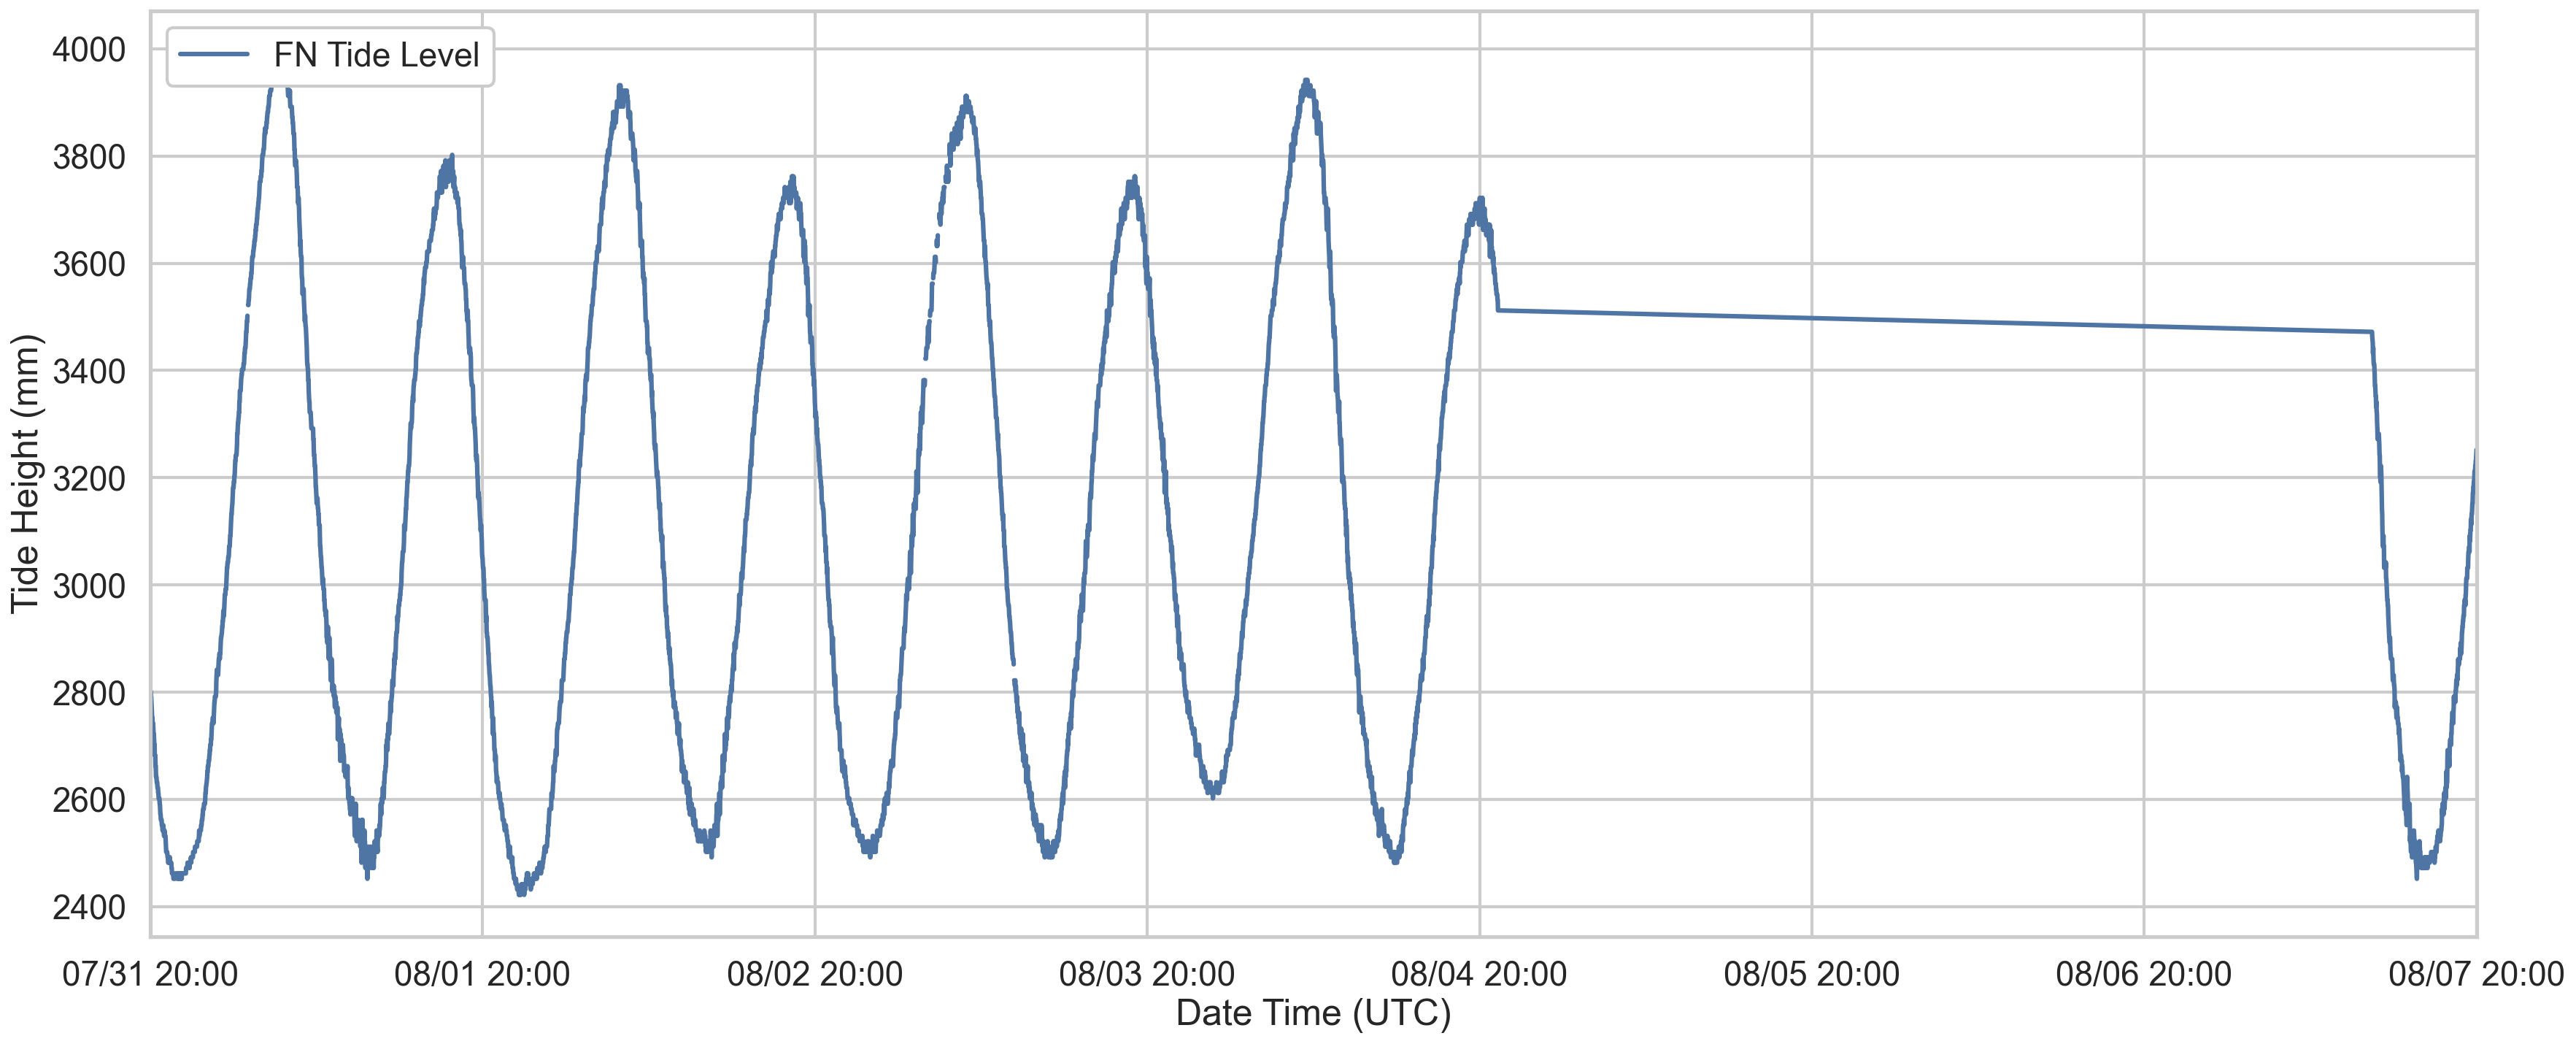

In [33]:
#Removing 5000s reading and Replotting
for index,range in df.iterrows():
    if df['dist_mm'][index] < 1600:
        df['dist_mm'][index] = None

y2 = np.array(df['dist_mm'])
x2 = np.array(df['time'])

figure, ax_arry = plt.subplots(nrows=1, sharex=True, figsize=(24, 10))
noaa_color = '#4e75a3'
sensor_color = '#3d805a'
ax_arry.plot(x2, y2, color=noaa_color, label='FN Tide Level')

ax_arry.set_xlim(pd.Timestamp(start), pd.Timestamp(end))
ax_arry.set_ylabel("Tide Height (mm)")
ax_arry.set_xlabel("Date Time (UTC)")
ax_arry.legend(framealpha=1, frameon=True, loc='upper left')
date_form = mdates.DateFormatter("%m/%d %H:%M")
ax_arry.xaxis.set_major_formatter(date_form)
plt.tight_layout(pad=1)
plt.show()



### Overlaying Floodnet and NOAA Tidal Data

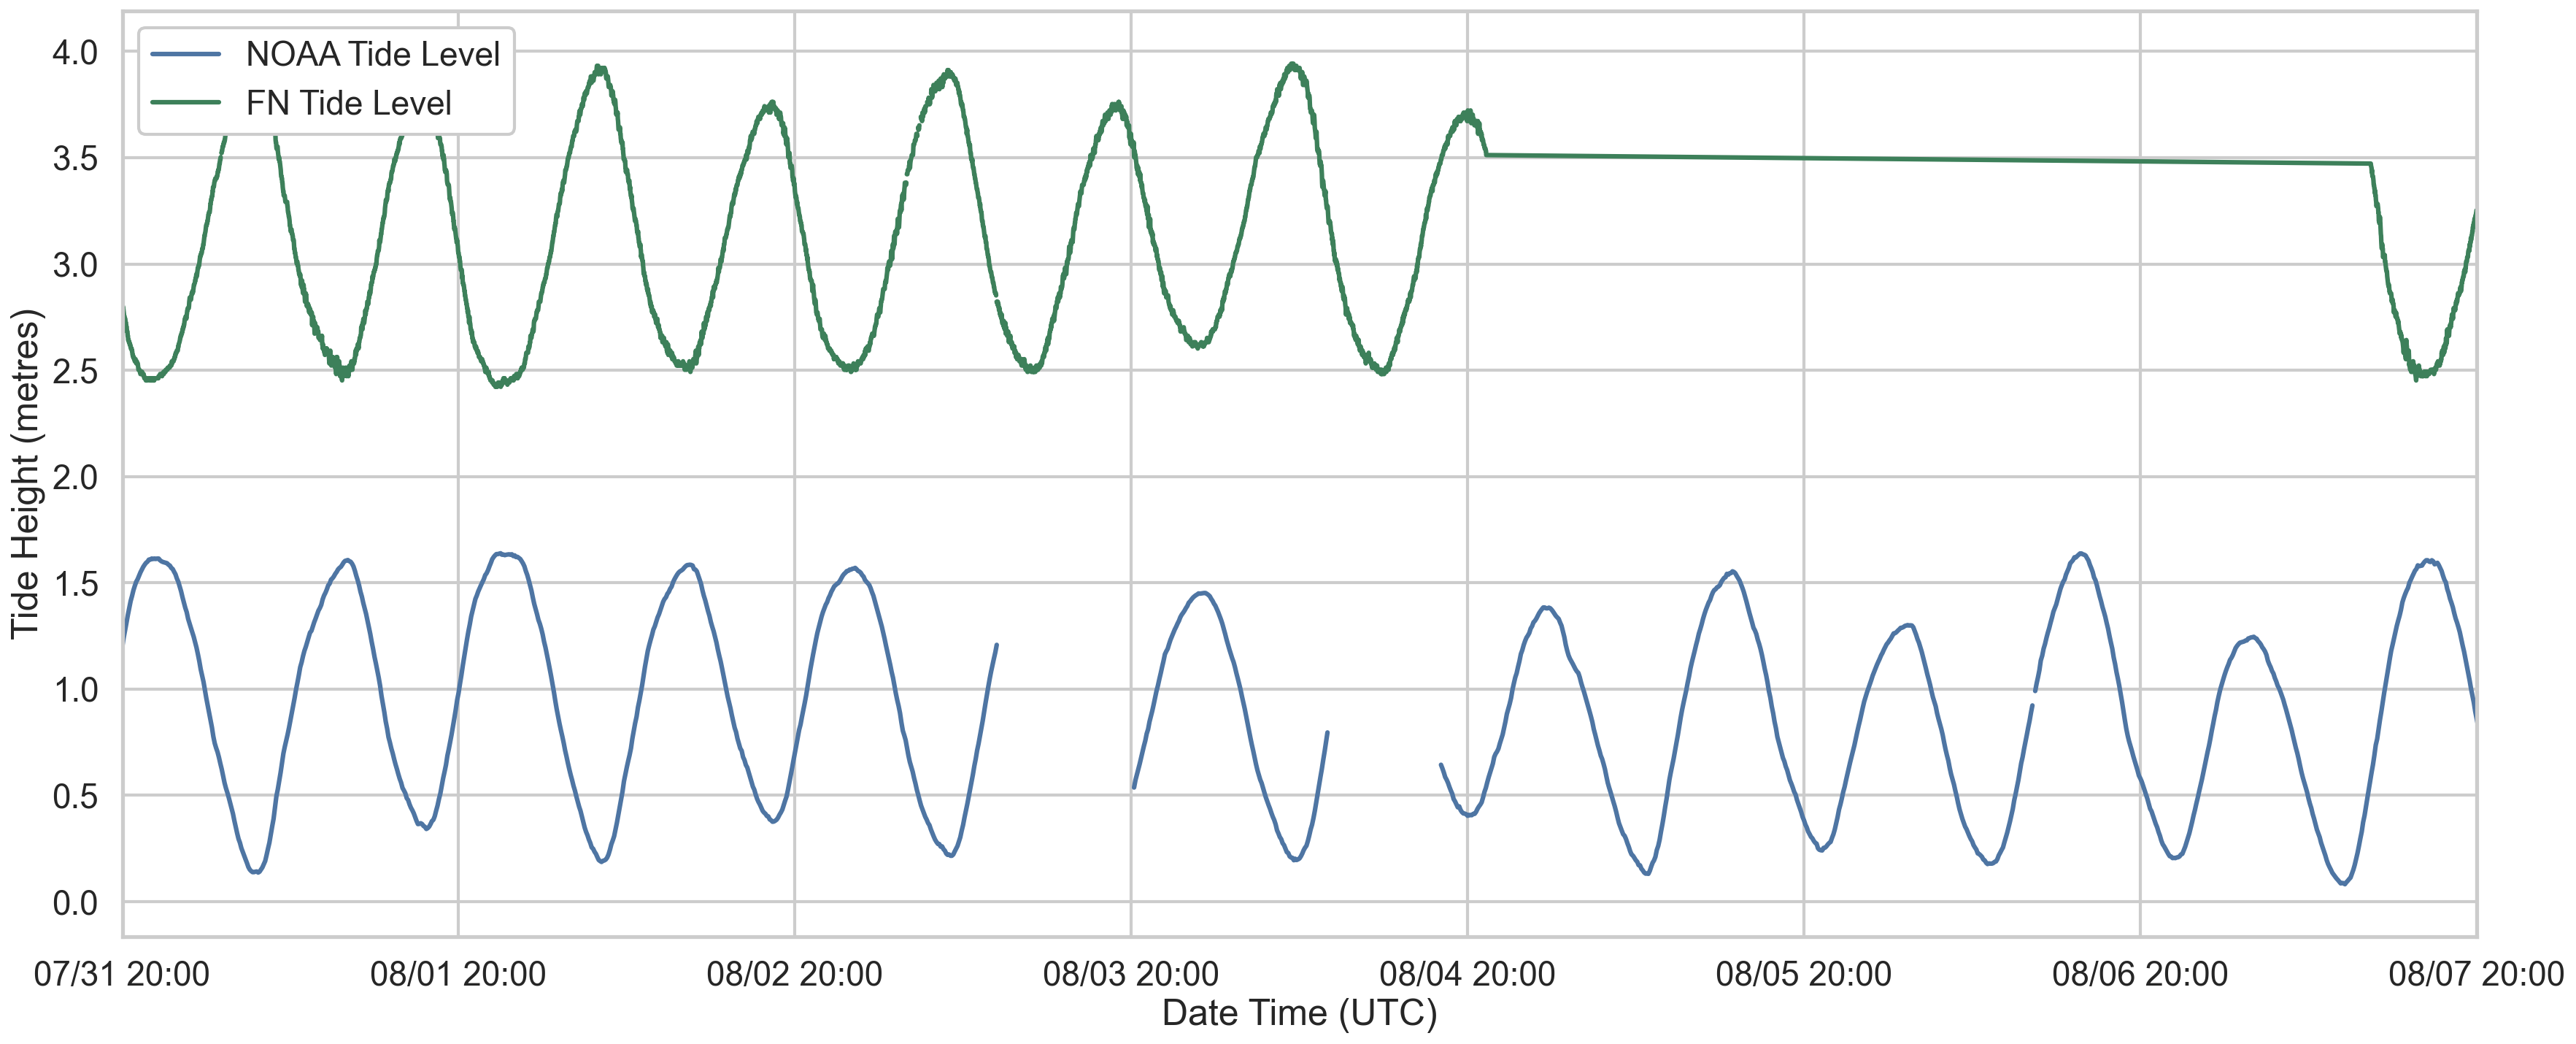

In [34]:
#Converting FN Measurment to metres

df['dist_m'] = df['dist_mm']/1000

#Plot
y2 = np.array(df['dist_m'])

figure, ax_arry = plt.subplots(nrows=1, sharex=True, figsize=(24, 10))
noaa_color = '#4e75a3'
sensor_color = '#3d805a'
ax_arry.plot(x1, y1, color=noaa_color, label='NOAA Tide Level')
ax_arry.plot(x2,y2, color=sensor_color, label = 'FN Tide Level')

ax_arry.set_xlim(pd.Timestamp(start), pd.Timestamp(end))
ax_arry.set_ylabel("Tide Height (metres)")
ax_arry.set_xlabel("Date Time (UTC)")
ax_arry.legend(framealpha=1, frameon=True, loc='upper left')
date_form = mdates.DateFormatter("%m/%d %H:%M")
ax_arry.xaxis.set_major_formatter(date_form)


plt.tight_layout(pad=1)
plt.show()

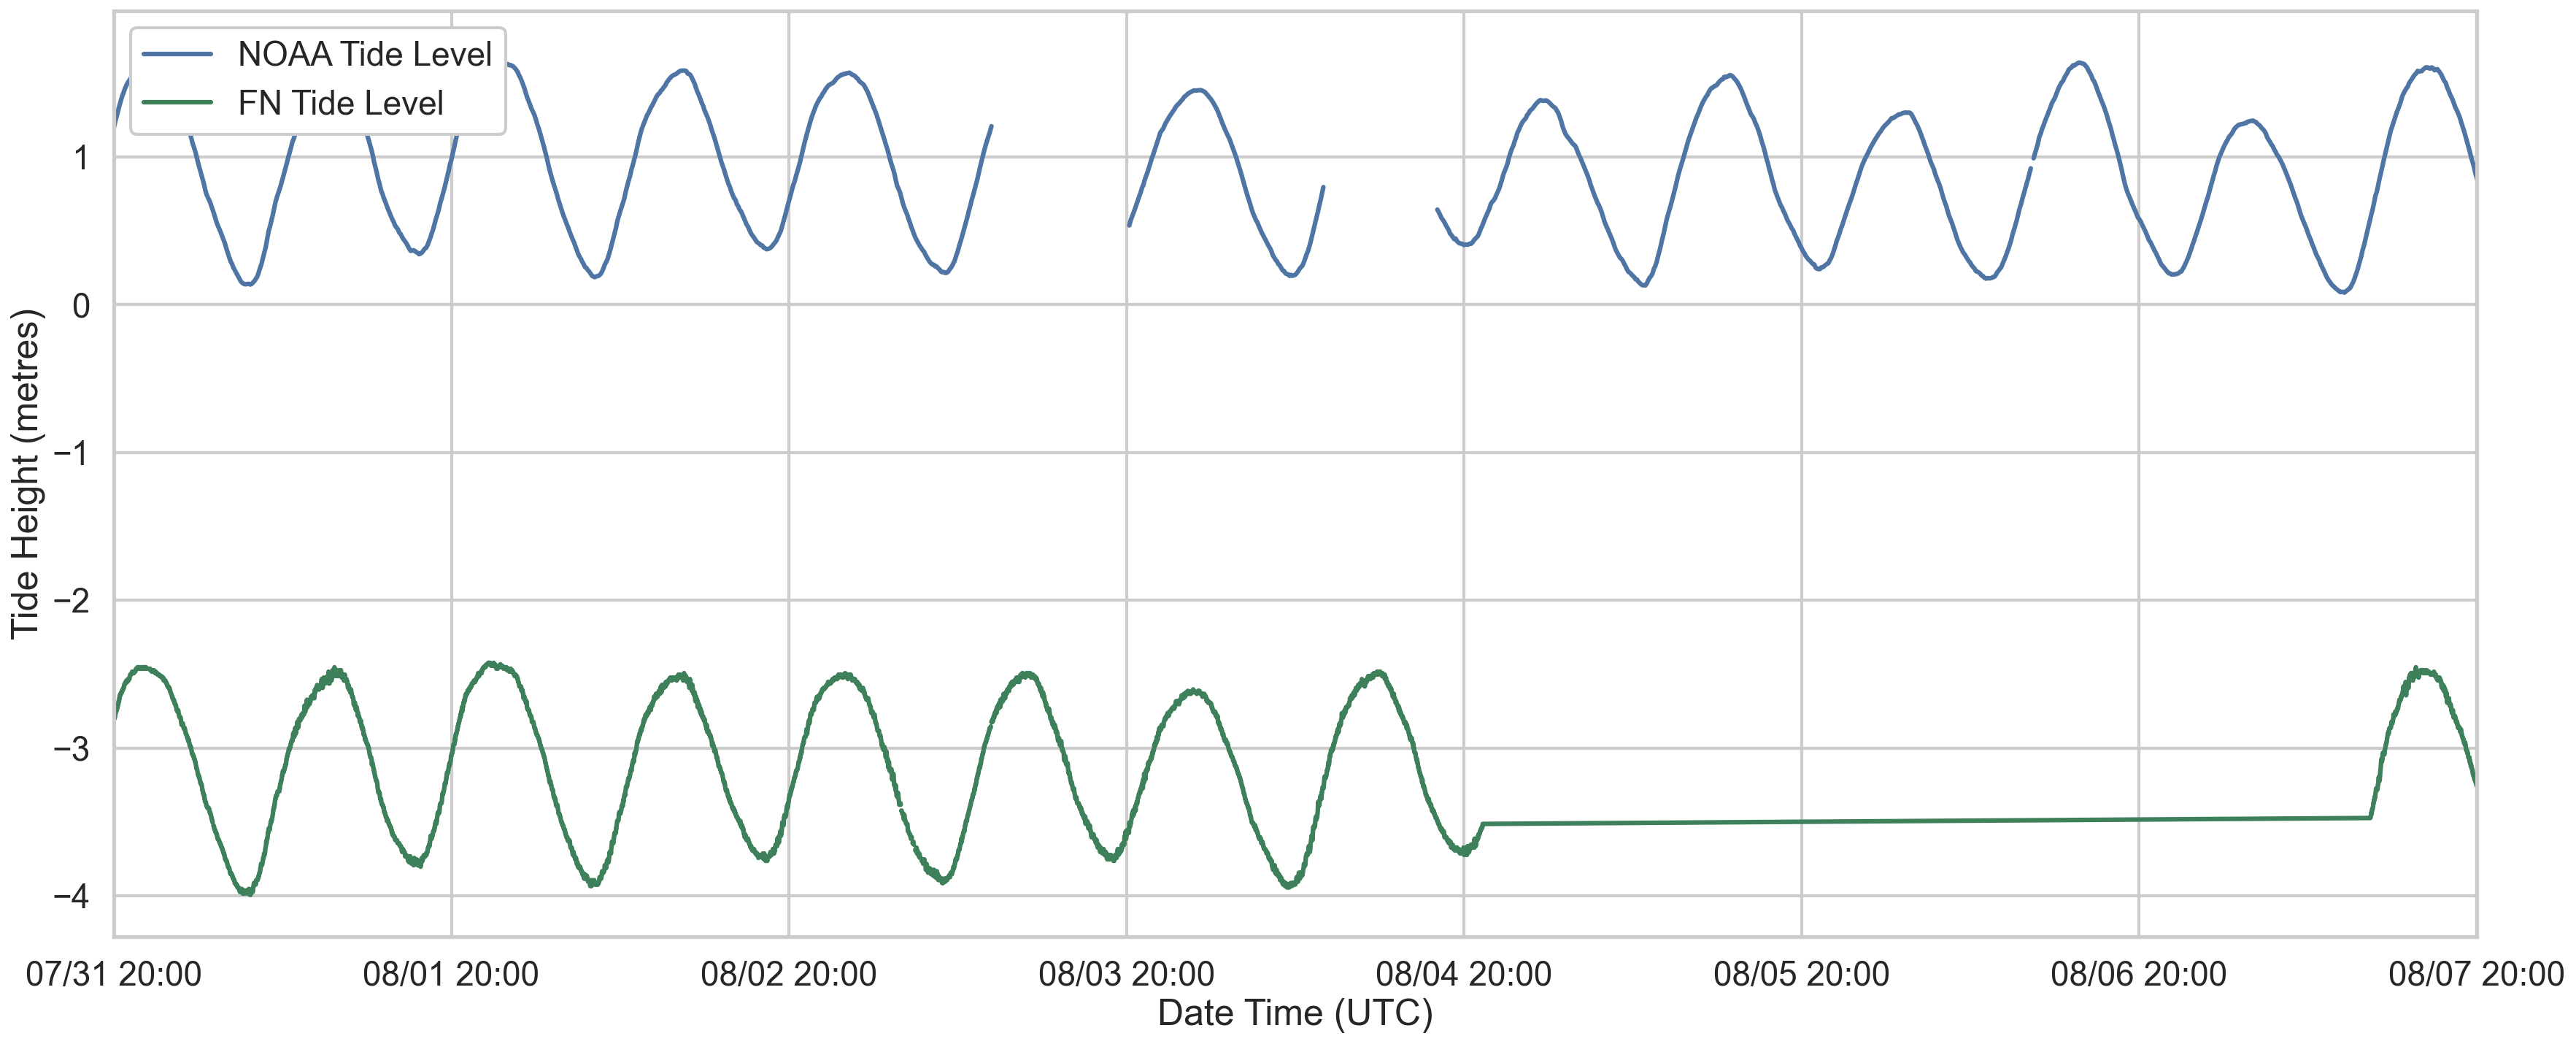

In [35]:
#Reflecting FN Data on x Axis

df['dist_m'] = -df['dist_m']

y2 = np.array(df['dist_m'])

figure, ax_arry = plt.subplots(nrows=1, sharex=True, figsize=(24, 10))
noaa_color = '#4e75a3'
sensor_color = '#3d805a'
ax_arry.plot(x1, y1, color=noaa_color, label='NOAA Tide Level')
ax_arry.plot(x2,y2, color=sensor_color, label = 'FN Tide Level')

ax_arry.set_xlim(pd.Timestamp(start), pd.Timestamp(end))
ax_arry.set_ylabel("Tide Height (metres)")
ax_arry.set_xlabel("Date Time (UTC)")
ax_arry.legend(framealpha=1, frameon=True, loc='upper left')
date_form = mdates.DateFormatter("%m/%d %H:%M")
ax_arry.xaxis.set_major_formatter(date_form)


plt.tight_layout(pad=1)
plt.show()


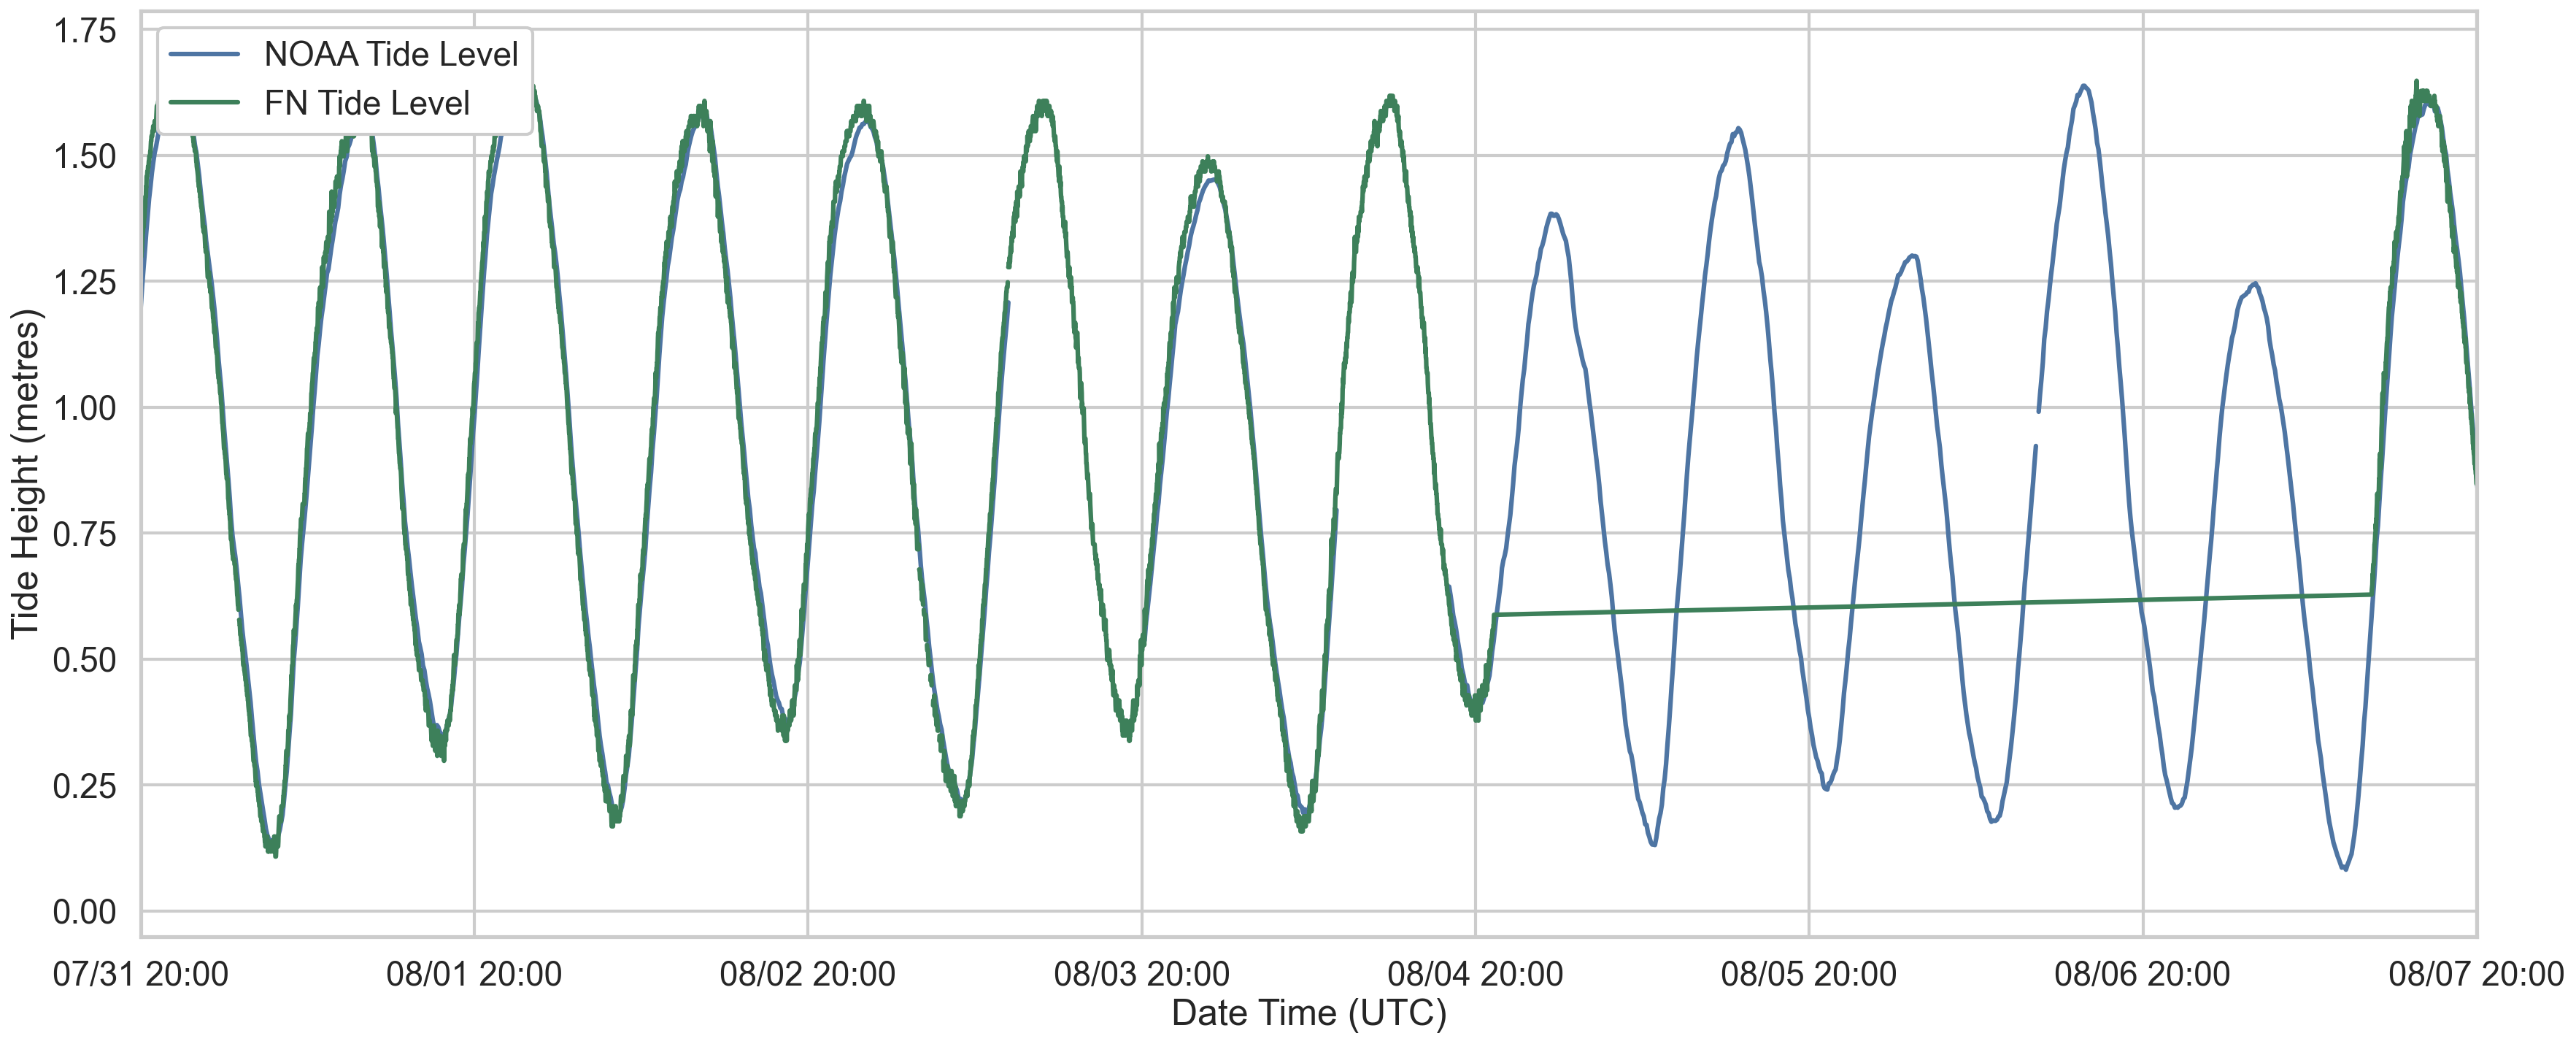

In [36]:
#Adding offset to FN measurement and plotting 
#Offset = 4.1 m

df['dist_m'] = df['dist_m'] + 4.1

y2 = np.array(df['dist_m'])

figure, ax_arry = plt.subplots(nrows=1, sharex=True, figsize=(24, 10))
noaa_color = '#4e75a3'
sensor_color = '#3d805a'
ax_arry.plot(x1, y1, color=noaa_color, label='NOAA Tide Level')
ax_arry.plot(x2,y2, color=sensor_color, label = 'FN Tide Level')

ax_arry.set_xlim(pd.Timestamp(start), pd.Timestamp(end))
ax_arry.set_ylabel("Tide Height (metres)")
ax_arry.set_xlabel("Date Time (UTC)")
ax_arry.legend(framealpha=1, frameon=True, loc='upper left')
date_form = mdates.DateFormatter("%m/%d %H:%M")
ax_arry.xaxis.set_major_formatter(date_form)


plt.tight_layout(pad=1)
plt.show()